In [231]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import torch

In [232]:
df_labeled = pd.read_csv("./training/training.csv")
df_test = pd.read_csv("./test/test.csv")

df = df_labeled.dropna(axis=0)
df_train, df_val = sk.model_selection.train_test_split(df)

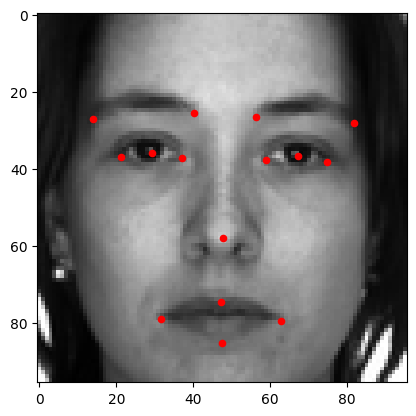

In [233]:
N_train = len(df_train)

i = np.random.randint(N_train)
row = df_train.iloc[i]
#print(row)

num_rows = 96
num_cols = 96
img = row["Image"].split()
img = np.array(img, dtype = "float64")
img = np.reshape(img, (num_rows, num_cols))

row = row.values[:-1] #Getting the image data
x_coords = row[::2] #seperating the x and y coordinates
y_coords = row[1::2]

plt.figure()
plt.imshow(img, cmap = "gray")
plt.scatter(x_coords,y_coords,s = 20, color = "red")

In [234]:
class KeyPointDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.num_rows = 96
        self.num_cols = 96
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = row['Image'].split()
        img = np.array(img, dtype="float32")/255
        img = np.reshape(img, (1, self.num_rows, self.num_cols))

        y = np.float32(row.values[:-1])

        return torch.tensor(img), torch.tensor(y)

In [235]:
dataset_train = KeyPointDataset(df_train)
dataset_val = KeyPointDataset(df_val)


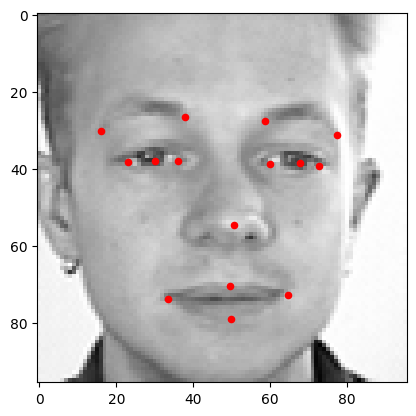

In [236]:
i = np.random.randint(N_train)
x, y =  dataset_train.__getitem__(i)
plt.imshow(x.squeeze(), cmap = "gray")
plt.scatter(y[::2], y[1::2], s = 20, color = "red")

In [237]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 16, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 16, shuffle = False)


In [238]:
x_batch, y_batch = next(iter(dataloader_train))

class KeyPointNetwork(torch.nn.Module):
    def __init__(self):

        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=(3,3), padding="same")
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=(3,3), padding="same")
        self.dense1 = torch.nn.Linear(32 * 48 * 48, 30)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size = 2)

        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.dense1(x)

        return x


In [239]:
model = KeyPointNetwork()
# print(model)

# print(x_batch.shape)
x_batch, y_batch = next(iter(dataloader_train))
y_pred = model(x_batch)
loss = torch.nn.functional.mse_loss(y_pred, y_batch)
print('loss is: ', loss)

loss is:  tensor(2675.2322, grad_fn=<MseLossBackward0>)


In [241]:
optimizer = torch.optim.Adam(model.parameters(), lr=.001)


N_train = len(dataset_train)
N_val = len(dataset_val)

num_epochs = 5

for _ in range(num_epochs):

    MSE_history_train = []
    MSE_history_val = []
    MSE = 0

    for x_batch,  y_batch in dataloader_train:

        outputs = model(x_batch)
        loss = torch.nn.functional.mse_loss(outputs, y_batch)
        model.zero_grad() #zero out any previous gradient calculations
        loss.backward()

        optimizer.step()

        MSE += loss * len(x_batch)

    MSE = MSE/N_train
    print("epoch is: ", _)
    print("MSE (training data) is: ", MSE)

    MSE = 0

    for x_batch, y_batch in dataloader_val:
        with torch.no_grad():
            outputs = model(x_batch)
            loss = torch.nn.functional.mse_loss(outputs, y_batch)
            MSE += loss * len(x_batch)
    
    MSE = MSE/N_val
    print("MSE (validation data) is: ", MSE)
    print()

epoch is:  0
MSE (training data) is:  tensor(14.0495, grad_fn=<DivBackward0>)
MSE (validation data) is:  tensor(8.4020)

epoch is:  1
MSE (training data) is:  tensor(8.1280, grad_fn=<DivBackward0>)
MSE (validation data) is:  tensor(7.7717)

epoch is:  2
MSE (training data) is:  tensor(5.7617, grad_fn=<DivBackward0>)
MSE (validation data) is:  tensor(5.4160)

epoch is:  3
MSE (training data) is:  tensor(4.3005, grad_fn=<DivBackward0>)
MSE (validation data) is:  tensor(5.6483)

epoch is:  4
MSE (training data) is:  tensor(3.9759, grad_fn=<DivBackward0>)
MSE (validation data) is:  tensor(5.3664)

